In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_opt, get_max_H_dist
import time
from epi.STG_Circuit import NetworkFreq, Simulate_all, NetworkFreq_all, Simulate
import tensorflow as tf
import os
DTYPE = tf.float32
figdir = "../../written/eLifeRevision/figures/fig1/"
#talkdir = "/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/"

### Model definition: STG

Here, we instantiate an `epi.Model` class by giving it a name and parameterization.  Here, the name is STG reflects the stomatogastric ganglion model we are analyzing.  Our two-parameter distribution consists of the electrical conductance $g_{el}$, which can vary from 4$\mu$S to 8$\mu$S, and a synaptic conductance $g_{synA}$, which can vary from 0.01$\mu$S to 4$\mu$S.  The non-zero lower bound on $g_{synA}$ is chosen to avoid pathological failure of network simulation.

The model name also reflects the parameterization of the current noise $\sigma_I$. It is often useful to add model hyperparameterization info to the name string to differentiate between different optimization results.

In [2]:
sigma_I = 1e-12
name = "STG_sigmaI=%.2E" % sigma_I

g_el = Parameter("g_el", 1, lb=4., ub=8.)
g_synA = Parameter("g_synA", 1, lb=0.01, ub=4.)
parameters = [g_el, g_synA]

model = Model(name, parameters)

### Emergent property definition: intermediate hub frequency

We want the hub neuron to spike at a frequency around 0.55Hz, which is between the frequency of the slow population (.33Hz) and the fast population (.68Hz). Since we desire a degree of variability in the frequency and this STG subcircuit model is stochastic, we specify a variance of (0.025 Hz)$^2$.

$$\mathcal{X} ~~\triangleq~~  \mathbb{E}_{\mathbf{z},\mathbf{x}}\begin{bmatrix} \omega_{\text{hub}}(\mathbf{x}; \mathbf{z}) \end{bmatrix} = \begin{bmatrix} 0.55 \end{bmatrix} $$
$$~~~~~~~~~~~~~  \text{Var}_{\mathbf{z},\mathbf{x}}\begin{bmatrix} \omega_{\text{hub}}(\mathbf{x}; \mathbf{z}) \end{bmatrix} = \begin{bmatrix} 0.025^2 \end{bmatrix} $$

In [3]:
mu_std = 0.025
mu = np.array([0.55, mu_std**2])
dt = 0.025
T = 300
network_freq = NetworkFreq(dt, T, sigma_I, mu)
model.set_eps(network_freq)

### Collect EPI results.

Over all five random seeds for our ideal EPI hyperparameter choice ($c_0 = 10^5$ and $\beta = 2$). We select the distribution with the greatest entropy.

In [4]:
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

epi_df = epi_df[epi_df['c0']==1e5]
epi_df = epi_df[epi_df['beta']==2.]

alpha, nu = 0.05, 0.25
dist, path, best_k = get_max_H_dist(model, epi_df, mu, alpha, nu)

path: data/epi/STG_sigmaI=1.00E-12/84b429dd14483c8a8093fc871a7e82a9/D2_C3_affine_L2_U25_PA_rs6/94952fa48a0262eceeabdeeddecb6803/N400_lr1.00E-03_c0=1.00E+05_gamma2.50E-01_beta2.00E+00
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


6: 0.77_0.12


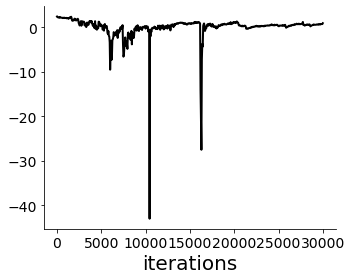

0 -
1 --


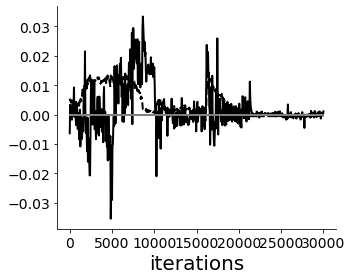

In [5]:
_epi_df = epi_df[epi_df['path']==path]
opt_figdir = "../../written/eLifeRevision/figures/figSTG1/"
_epi_df = epi_df[epi_df['path'] == path]
plot_opt(_epi_df, max_k=best_k, fontsize=20, figdir=opt_figdir, save=True)

### Sample the EPI posterior.

In [6]:
M = 500
s = 50
np.random.seed(1)
tf.random.set_seed(1)

z, log_q_z = dist.nf(M)
z = z.numpy()
log_q_z = log_q_z.numpy()
T_x = model.eps(z).numpy()
z_mode = z[np.argmax(log_q_z),:][None,:]

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


### Calculate error contours.

In [7]:
xlim = [np.min(z[:,1]), np.max(z[:,1])]
ylim = [np.min(z[:,0]), np.max(z[:,0])]
limbuf = 0.

K = 51
x = np.linspace(xlim[0]+limbuf, xlim[1]-limbuf, K)
y = np.linspace(ylim[0]+limbuf, ylim[1]-limbuf, K)
m = K**2

Z_mesh = np.meshgrid(x, y, indexing='ij')
_Z_grid = np.zeros((m,2))
_Z_grid[:,0] = np.reshape(Z_mesh[1], (m,))
_Z_grid[:,1] = np.reshape(Z_mesh[0], (m,))

print("calculating T_x_grid")
T_x_grids = []
N_T_x = 25
for i in range(N_T_x):
    print('%2d/%2d\r' % (i+1, N_T_x), end="")
    T_x_grids.append(np.reshape(model.eps(_Z_grid)[:,0], (K, K)))
T_x_grids = np.array(T_x_grids)
T_x_grid = np.mean(T_x_grids, axis=0)
T_x_grid_std = np.std(T_x_grids, axis=0)

# Keep contours monotonic.
for k in range(K):
    for j in range(20,K):
        if ((T_x_grid[j,k] > T_x_grid[j-1,k]) and
            (T_x_grid[j-1,k] > T_x_grid[j-2,k])):
            T_x_grid[(j-2):,k] = .49
            break

temp = T_x_grid[30:]
temp[temp > .55] = .49
T_x_grid[30:] = temp

calculating T_x_grid


### Calculate the Hessian and test parameters along its eigenvectors.

calculate hessian
took 5.871485948562622 seconds


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


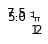

In [8]:
print('calculate hessian')
start_time = time.time()
hess = dist.hessian(z_mode)
total_time = time.time() - start_time
print('took', total_time, 'seconds')

# Take eigendecomposition of Hessian.
d, V = np.linalg.eig(hess[0])
d_order = np.argsort(d)
d = np.array([d[i] for i in d_order])
V = np.array([V[:,i] for i in d_order])

# Orient eigenvectors in consistent direction.
if (V[1,0] < 0):
    V[:,0] = -V[:,0]
if (V[1,1] < 0):
    V[:,1] = -V[:,1]
    
# Determine points to simulate along eigenvectors of Hessian.
V_proj = 1.1
z1 = z_mode + V_proj*V[:,0][None,:]
z2 = z_mode + V_proj*V[:,1][None,:]
z_stars = np.concatenate((z_mode, z1,z2), axis=0)

# Get log probability colors of all sampled parameters including starred points.
log_q_z_stars = dist.log_prob(z_stars)
plt.figure(figsize=(.1, .1))
sc = plt.scatter(z[:,1], z[:,0], log_q_z)
log_q_zs_c = np.concatenate((log_q_z, log_q_z_stars[[0, 2]]), axis=0)
cs = sc.to_rgba(log_q_zs_c)
c_star = np.array([cs[-2], cs[np.argmin(log_q_zs_c)], cs[-1]])

In [9]:
"""H_tf = np.array([[0.00199881, 0.00420201], [0.00419833, -0.06453793]])
print(H_tf)
d_tf, V_tf = np.linalg.eig(H_tf)
print(d_tf)
print(V_tf)"""

'H_tf = np.array([[0.00199881, 0.00420201], [0.00419833, -0.06453793]])\nprint(H_tf)\nd_tf, V_tf = np.linalg.eig(H_tf)\nprint(d_tf)\nprint(V_tf)'

In [10]:
# Uncomment for making talk slides.
#labels = ["", ""]
#fig, axs = pairplot(z, range(2), labels, figsize=(4,4), s=s,
#                     fontsize=22, lb=np.array([4.5, 0.]), ub=np.array([8, 3.5]),
#                     c=log_q_z, c_label='')
#plt.tight_layout()
#plt.savefig(os.path.join(talkdir, "EPI_STG_basic.png"))

# Figure 1E

The EPI posterior, error contours, and test parameters.

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


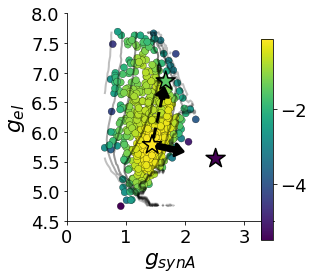

In [11]:
num_levels = 7
levels = np.linspace(0.5125, 0.5875, num_levels)

fig, axs = plt.subplots(1,1,figsize=(4,4))
colors = np.zeros((num_levels, 4))
mid_level_ind = (num_levels-1)//2
colors[:,3] = 0.25*(1. - np.abs((np.arange(num_levels) - mid_level_ind) /mid_level_ind)) + 0.25
axs.contour(Z_mesh[0], Z_mesh[1], T_x_grid, levels, colors=colors)

v_scale_start1 = .3
v_scale_start2 = .2
v_scale_end = 1.75
v1_start = (z_mode[0,0] + (v_scale_start1 / np.sqrt(np.abs(d[0]))*V[0,0]), 
            z_mode[0,1] + (v_scale_start1 / np.sqrt(np.abs(d[0]))*V[1,0]))
v2_start = (z_mode[0,0] + (v_scale_start2 / np.sqrt(np.abs(d[1]))*V[0,1]), 
            z_mode[0,1] + (v_scale_start2 / np.sqrt(np.abs(d[1]))*V[1,1]))
v1_end = (z_mode[0,0] + (v_scale_end / np.sqrt(np.abs(d[0]))*V[0,0]), 
          z_mode[0,1] + (v_scale_end / np.sqrt(np.abs(d[0]))*V[1,0]))
v2_end = (z_mode[0,0] + (v_scale_end / np.sqrt(np.abs(d[1]))*V[0,1]), 
          z_mode[0,1] + (v_scale_end / np.sqrt(np.abs(d[1]))*V[1,1]))

ratio = 0.8
v2_mid = ((1-ratio)*v2_start[0]+ratio*v2_end[0], (1-ratio)*v2_start[1]+ratio*v2_end[1])
axs.plot([v2_start[1], v2_mid[1]], [v2_start[0], v2_mid[0]], 'k--', lw=3)
axs.annotate("", xy=[v1_end[1], v1_end[0]], xytext=[v1_start[1], v1_start[0]], 
             arrowprops=dict(headwidth=12, headlength=8, lw=3, color='k'))
axs.annotate("", xy=[v2_end[1], v2_end[0]], xytext=[v2_mid[1], v2_mid[0]], 
             arrowprops=dict(headwidth=12, headlength=8, lw=3, color='k'))

labels = [r"$g_{el}$", r"$g_{synA}$"]
fig, axs = pairplot(z, range(2), labels, s=s, subplots=(fig,axs),
                     fontsize=22, lb=np.array([4.5, 0.]), ub=np.array([8, 3.5]),
                     c=log_q_z, c_label='', starred=z_stars, c_starred=c_star)

plt.tight_layout()
plt.savefig(figdir + 'EPI_z.png', dpi=300)

# Figure 1F

The post

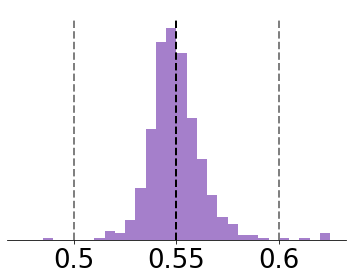

In [18]:
from epi.util import plot_T_x

#xlabels = [r"$\omega_{hub}(x; z)$"]
xlabels = [""]
ax = plot_T_x(None, T_x[:,0], xmin=0.475, xmax=0.625, 
         x_mean = mu[0], x_std = np.sqrt(mu[1]),
         xlabel=xlabels[0], figsize=(5,4), #figsize=(5,2.25), 
         fontsize=30)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig(os.path.join(talkdir, 'STG_Tx.png'), transparent=True)
plt.savefig(os.path.join(figdir, 'Tx.png'), transparent=True)

tf.Tensor([0.53999996 0.53999996 0.53999996 0.53999996 0.53999996], shape=(5,), dtype=float32)


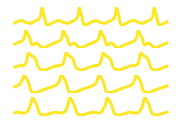

tf.Tensor([0.6699999  0.6500136  0.42999998 0.42999998 0.42999998], shape=(5,), dtype=float32)


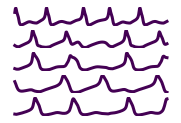

tf.Tensor([0.53999996 0.53999996 0.53999996 0.53999996 0.53999996], shape=(5,), dtype=float32)


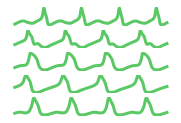

In [13]:
np.random.seed(0)
tf.random.set_seed(0)
dt = 0.025
T_sim = 1000

network_freq_all = NetworkFreq_all(dt, T_sim, sigma_I, mu)
outs = [network_freq_all(np.array([[z_stars[i,0]]]), np.array([[z_stars[i,1]]])) for i in range(3)]
x_ts = [outs[i][0] for i in range(3)]
omegas = [outs[i][1] for i in range(3)]

T_plot = 301
t = dt*np.arange(T_plot)
num_neurons = 5
figsize = (3,num_neurons*0.4)
for i in range(3):
    fig, axs = plt.subplots(num_neurons, 1, figsize=figsize)
    print(omegas[i][:5,0])
    for k in range(num_neurons):
        axs[k].plot(t, x_ts[i][-T_plot:,k], color=c_star[i], lw=3)
        axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
        axs[k].set_xticks([])
        axs[k].set_yticks([])
    plt.savefig(os.path.join(figdir, 'x_%d.png' % (i+1)), transparent=True)
    #plt.savefig(os.path.join(talkdir, 'x_%d.png' % (i+1)), transparent=True)
    plt.show()
    

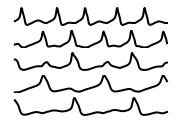

In [14]:
dt = 0.025
T_sim = 2000
sigma_I = 5e-13
simulate_all = Simulate_all(dt, T, sigma_I)
x_t = simulate_all(np.array([[4.5]]), np.array([[3.]]))
omega = network_freq_all(np.array([[4.5]]), np.array([[3.]]))

fig, axs = plt.subplots(num_neurons, 1, figsize=figsize)
for k in range(num_neurons):
    axs[k].plot(t, x_t[-T_plot:,k], color='k', lw=2)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
    axs[k].set_xticks([])
    axs[k].set_yticks([])
plt.savefig(os.path.join(figdir, 'x_eg.png'), transparent=True)
plt.show()

In [15]:
T = 350
simulate = Simulate(dt, T, sigma_I)
x_t = simulate(z[:,0][:,None], z[:,1][:,None]).numpy()


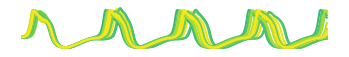

In [16]:
figsize = (6,0.8)
n_plot = 25
to_plot = -2. < log_q_z 
#to_plot = np.logical_and(-2. < log_q_z, log_q_z  < 0.) 
x_t_plot = x_t[:, to_plot]
cs_plot = cs[:-2][to_plot]
fig, axs = plt.subplots(1, 1, figsize=figsize)
for i in range(n_plot):
    axs.plot(t, x_t_plot[-T_plot:,i], color=cs_plot[i], lw=2)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_xticks([])
axs.set_yticks([])
#plt.savefig(os.path.join(talkdir, 'EP_STG.png'), transparent=True)
plt.savefig(os.path.join(figdir, 'x_EP.jpg'), transparent=True)
plt.show()